In [145]:
from time import time
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [146]:
#define the states
x1 = ca.SX.sym('x1')
x2 = ca.SX.sym('x2')
x = ca.vertcat(x1, x2)

#define th controls
u = ca.SX.sym('u')

# Van der Pol oscillator system (nonlinear ODE)
ode = ca.vertcat(x2, (1-x1**2)*x2 - x1 + u)

# ODE right-hand side function
f = ca.Function('f', [x, u], [ode], ['x', 'u'], ['ode'])

T = 10
N = 100
sim_time = 20
step_horizon = T/N

# this integration options will integrate for 0.1 seconds
intg_options = {"tf": T/N, 'simplify': True, 'number_of_finite_elements': 4}

#check if f is working by giving f(x, u) and t = 0
# print(f(ca.vertcat(0.2, 0.3), 0.4))
dae = {'x': x, 'ode': ode, 'p': u}
# here p is parameters or stuffs that don't change during integration
#this intg object is a discretized version of the ode
intg = ca.integrator('intg', 'rk', dae, intg_options)

res = intg(x0=x,p=u)
x_next = res['xf']

n_states = x.numel()
n_controls = u.numel()

In [147]:
# given (x,u) compute x_next using F API
F = ca.Function('F', [x, u], [x_next], ['x', 'u'], ['x_next'])
P = ca.SX.sym('P', n_states + n_states)
X = ca.SX.sym('X', n_states, (N+1))
U = ca.SX.sym('U', n_controls, N)

In [148]:
X[:,0] = P[:n_states]
for k in range(N):
    st = X[:,k]
    con = U[:,k]
    f_value = F(st, con)
    st_next = f_value
    X[:,k+1] = st_next

#symbolic expression for optimal trajectory given the current(initialization) state and the control input
ff = ca.Function('ff', [U, P], [X], ['U', 'P'], ['X'])

ff

Function(ff:(U[1x100],P[4])->(X[2x101]) SXFunction)

In [149]:
Q = np.diag([1, 1])
R = np.diag([0.1])

#compute the objective symbolically
obj = 0
for k in range(N):
    st = X[:,k]
    con = U[:,k]
    obj = obj + ca.mtimes([(st-P[n_states:]).T, Q, (st-P[n_states:])]) + ca.mtimes([con.T, R, con])
    

In [150]:
opt_variables = U.reshape((n_controls*N,1))

In [151]:
def shift_timestep(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (step_horizon * f_value))
    #print(next_state.shape)
    next_state = F(state_init, u[:, 0])
    #print(next_state.shape)
    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0


def DM2Arr(dm):
    return np.array(dm.full())

In [155]:
nlp_prob = {'f': obj, 'x': opt_variables, 'p': P}
opts = {'ipopt': {'max_iter': 2000, 'print_level': 0, 'acceptable_tol': 1e-8, 'acceptable_obj_change_tol': 1e-6}, 'print_time': False}

t0 = 0
state_init = ca.DM([0, 1])        # initial state
state_target = ca.DM([0,0])  # target state

xx = ca.DM.zeros((n_states, int(sim_time/step_horizon)+1))
xx[:,0] = state_init
t = ca.DM(t0)

u0 = ca.DM.zeros((n_controls, N))  # initial control
xx1 = np.zeros((n_states, N+1, int(sim_time/step_horizon)))
u_cl = ca.DM.zeros((n_controls, int(sim_time/step_horizon)))  # closed-loop control

print(u0.shape)
print(u_cl.shape)
mpc_iter = 0
solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)
args={}

(1, 100)
(1, 200)


In [153]:
main_loop = time()  # return time in sec
times = np.array([[0]])
while (ca.norm_2(state_init - state_target) > 1e-5) and (mpc_iter * step_horizon < sim_time): # 0.1*200
    t1 = time()
    args['p'] = ca.vertcat(
        state_init,    # current state
        state_target   # target state
    )
    # optimization variable current state
    args['x0'] = ca.reshape(u0.T, n_controls*(N), 1)
    sol = solver(x0=args['x0'], p=args['p'])

    u = ca.reshape(sol['x'].T, n_controls, N)
    ff_value = ff(u.T, args['p'])
    #print(DM2Arr(ff_value).T.shape)
    xx1[:,:N+1,mpc_iter+1] = DM2Arr(ff_value)

    print(u_cl.shape)
    print(u.shape)
    u_cl = ca.horzcat(u_cl[:,1:], u[:,0])
    #append the last time step
    t = np.vstack((t,t0))

    t0, state_init, u0 = shift_timestep(step_horizon, t0, state_init, u, f)

    xx[:,mpc_iter+1] = state_init.T

    mpc_iter = mpc_iter + 1
    t2 = time()
    print("mpc iteration", mpc_iter)
    print(t2-t1)
    times = np.vstack((times,t2-t1))

main_loop_time = time()
ss_error = ca.norm_2(state_init - state_target)
print('\n\n')
print('Total time: ', main_loop_time - main_loop)
print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')
print('final error: ', ss_error)

(1, 200)
(1, 100)
mpc iteration 1
0.3165311813354492
(1, 200)
(1, 100)
mpc iteration 2
0.023500680923461914
(1, 200)
(1, 100)
mpc iteration 3
0.0230863094329834
(1, 200)
(1, 100)
mpc iteration 4
0.0189816951751709
(1, 200)
(1, 100)
mpc iteration 5
0.018562793731689453
(1, 200)
(1, 100)
mpc iteration 6
0.017231225967407227
(1, 200)
(1, 100)
mpc iteration 7
0.01503753662109375
(1, 200)
(1, 100)
mpc iteration 8
0.014409303665161133
(1, 200)
(1, 100)
mpc iteration 9
0.01588726043701172
(1, 200)
(1, 100)
mpc iteration 10
0.015916109085083008
(1, 200)
(1, 100)
mpc iteration 11
0.01556253433227539
(1, 200)
(1, 100)
mpc iteration 12
0.016481637954711914
(1, 200)
(1, 100)
mpc iteration 13
0.015855789184570312
(1, 200)
(1, 100)
mpc iteration 14
0.016538619995117188
(1, 200)
(1, 100)
mpc iteration 15
0.015720605850219727
(1, 200)
(1, 100)
mpc iteration 16
0.016982555389404297
(1, 200)
(1, 100)
mpc iteration 17
0.01609063148498535
(1, 200)
(1, 100)
mpc iteration 18
0.02136540412902832
(1, 200)
(1,

(1, 200)


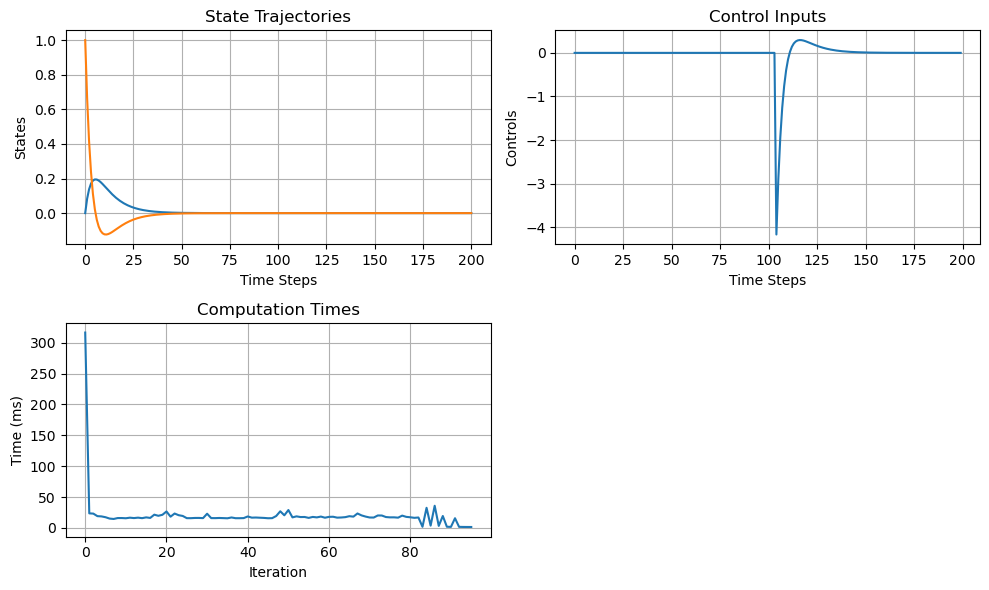

In [154]:
import matplotlib.pyplot as plt
# Plot state trajectories
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(xx.T)
plt.title('State Trajectories')
plt.xlabel('Time Steps')
plt.ylabel('States')
plt.grid(True)

# Plot control inputs
plt.subplot(2, 2, 2)
print(u_cl.shape)
u_cl_np = np.array(u_cl)  # Convert to numpy array if not already
plt.plot(u_cl_np.T)
plt.title('Control Inputs')
plt.xlabel('Time Steps')
plt.ylabel('Controls')
plt.grid(True)

# Plot computation times
plt.subplot(2, 2, 3)
times_np = np.array(times[1:])  # Convert to numpy array and skip the first element (initialization)
plt.plot(times_np * 1000)  # Convert to milliseconds
plt.title('Computation Times')
plt.xlabel('Iteration')
plt.ylabel('Time (ms)')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()